In [1]:
# Import statements
import numpy as np
import matplotlib.pyplot as pt
import glob
import time
import os
import shutil
import pathlib
import matplotlib

from ase.io import read
from pyiron import Project, ase_to_pyiron

from molmod.units import *
from molmod.constants import *

from collections import namedtuple, Counter
from dataclasses import dataclass # replaces namedtuple with mutable attributes
%matplotlib inline

matplotlib.rcParams.update({'font.size': 10})


In [2]:
# Create project for rotational barriers characterization
pr = Project('barriers')

In [3]:
# g16 job function
def g16_job(pr, structure, name, jobtype='sp', lot='B3LYP', basis_set='6-311++G(d,p)', settings={'EmpiricalDispersion':['GD3'], 'int':['grid=ultrafine'], 'scf':['tight','maxcycle=5000']}, suffix=None, cores=9, run_time=60*60):
    job = pr.create_job(pr.job_type.Gaussian, name, delete_existing_job=True)
    job.structure = structure
    job.input['jobtype'] = jobtype
    job.input['lot'] = lot
    job.input['basis_set'] = basis_set
    
    if not settings is None:
        job.input['settings'] = settings
        
    if suffix is not None:
        job.input['suffix'] = suffix
        
    job.executable.version = '2019_mpi' # to work in kirlia
    
    job.server.queue = 'kirlia'
    job.server.cores = cores
    job.server.run_time = run_time # in seconds
    
    job.run()

In [4]:
# g16 job function
def g16_gic_job(pr, structure, name, jobtype='opt', lot='B3LYP', basis_set='6-311++G(d,p)', settings={'EmpiricalDispersion':['GD3'], 'int':['grid=ultrafine'], 'scf':['tight','maxcycle=5000'], 'geom':['addgic'], 'nosymm':[]}, suffix=None, run_time=2*60*60):
    job = pr.create_job(pr.job_type.Gaussian, name, delete_existing_job=True)
    job.structure = structure
    job.input['jobtype'] = jobtype
    job.input['lot'] = lot
    job.input['basis_set'] = basis_set
    
    if not settings is None:
        job.input['settings'] = settings
        
    if suffix is not None:
        job.input['suffix'] = suffix
        
    job.executable.version = '2019_mpi' # to work in kirlia
    
    job.server.queue = 'kirlia'
    job.server.cores = 9
    job.server.run_time = run_time # in seconds
    
    job.run()

In [7]:
# yaff job function
def yaff_opt_job(pr, name, structure, ffs, ffpars):
    job = pr.create_job(pr.job_type.Yaff, name, delete_existing_job=True)
    
    job.calc_minimize(max_iter=10000)

    job.input['ffpars'] = ffpars
    job.structure = structure
    job.ffatypes = ffs.ffatypes
    job.ffatype_ids = ffs.ffatype_ids
    job.bonds = ffs.bonds

    job.server.queue = 'victini'
    job.server.cores = 1
    job.server.run_time = 5*60*60 # in seconds

    job.run()


In [8]:
# yaff job function
def yaff_scan_job(pr, name, sinfo, ffpars):
    job = pr.create_job(pr.job_type.Yaff, name, delete_existing_job=True)
    job.structure = sinfo.ff.structure
    job.input['ffpars'] = ffpars # separate to allow for varying ffpars
    
    job.ffatypes = sinfo.ff.ffatypes
    job.ffatype_ids = sinfo.ff.ffatype_ids
    job.bonds = sinfo.ff.bonds

    job.calc_scan(np.arange(sinfo.range_min, sinfo.range_max+sinfo.range_step, sinfo.range_step), adapt_structure=sinfo.adapt_structure)
    job.server.queue = 'victini'
    job.server.cores = 1
    job.server.run_time = 15*60 # in seconds   
    job.run()


In [9]:
# yaff job function
def yaff_scan_structures_job(pr, name, sinfo, ffpars, structures):
    job = pr.create_job(pr.job_type.Yaff, name, delete_existing_job=True)
    job.structure = sinfo.ff.structure
    job.input['ffpars'] = ffpars # separate to allow for varying ffpars
    
    job.ffatypes = sinfo.ff.ffatypes
    job.ffatype_ids = sinfo.ff.ffatype_ids
    job.bonds = sinfo.ff.bonds

    job.calc_scan(np.arange(sinfo.range_min, sinfo.range_max+sinfo.range_step, sinfo.range_step),structures=structures)
    job.server.queue = 'victini'
    job.server.cores = 1
    job.server.run_time = 15*60 # in seconds   
    job.run()

## Perform AI scans

### Functions

In [10]:
'''@dataclass
class ff_object:
    structure: object
    ffpars: object
    ffpars_nodih: object
    ffpars_polysix: object
    ffatypes: object
    ffatype_ids: object
    bonds : object'''
        
        
class FFobject(object):
    def __init__(self,block_name,structure,ffatypes,ffatype_ids,bonds,fnames,fn_ai,ffpars_nodih=None,ffpars_polysix=None):
        self.block_name = block_name
        self.structure = structure
        self.ffatypes = ffatypes
        self.ffatype_ids = ffatype_ids
        self.bonds = bonds
        self.fnames = fnames
        self.ffpars = self._set_ffpars()
        self.fn_ai = fn_ai
        self.ffpars_nodih = ffpars_nodih
        self.ffpars_polysix = ffpars_polysix
        
    def _set_ffpars(self):
        ffpars = ''
        for fn in self.fnames:
            with open(fn,'r') as f:
                ffpars+=f.read()
        return ffpars

In [11]:
# Structure info and rotation grid
class Sinfo(object):
    def __init__(self,pr,ff,indices,mask=None,range_min=0,range_max=90,range_step=1,degeneracy=None, fit_indices=None):
        self.pr = pr
        self.ff = FFobject(ff.block_name,ff.structure,ff.ffatypes,ff.ffatype_ids,ff.bonds,ff.fnames,ff.fn_ai,ffpars_nodih=ff.ffpars_nodih,ffpars_polysix=ff.ffpars_polysix) # create new object to avoid overwritten when using the same FFObject for difference sinfos
        self.indices = indices
        self.mask = mask
        self.mask_indices = None 
        self.range_min = range_min
        self.range_max = range_max
        self.range_step = range_step
        self.degeneracy = degeneracy
        
        self.fit_indices = fit_indices
        
        self._set_mask_indices()
        self.adapt_structure = self._set_adapt_structure()
        
        
    # Define function to identify mask for rotation
    @staticmethod
    def get_mask(structure,indices):
        # Assume that we can define mask by taking all atoms in the direction of the dihedral
        ref_vector = structure.positions[indices[2]] - structure.positions[indices[1]]
        mask = np.array([np.dot(pos - structure.positions[indices[1]], ref_vector) >= 0 for pos in structure.positions],dtype=np.int)
        return mask
        
    def _set_mask_indices(self):
        if self.mask is None:
            self.mask = self.get_mask(self.ff.structure,self.indices)
        else:
            if len(self.mask)<len(self.ff.structure):
                self.mask_indices = copy.copy(self.mask)
                self.mask = None
            else:
                assert len(self.mask)==len(self.ff.structure)
                self.mask_indices=None
                
    def _set_adapt_structure(self):
        
        def adapt_structure(structure,angle,idx=self.indices,mask=self.mask,indices=self.mask_indices):
            new_structure = self.ff.structure.copy()
            new_structure.set_dihedral(*idx,angle=angle,mask=mask,indices=indices) # angle in degrees
            return new_structure
        
        return adapt_structure
                
    def get_sub_project_name(self,key,suffix=None):
        if suffix is not None:
            return 'barriers/{}/{}_{}_{}'.format(self.pr.name,key,"_".join([str(i) for i in self.indices]),suffix)
        else:
            return 'barriers/{}/{}_{}'.format(self.pr.name,key,"_".join([str(i) for i in self.indices]))

In [69]:
# ICs check (only dihedral can change)

from yaff import *
from yaff.log import *
import copy

log.set_level(0)

def get_ICs(system, ics):
    num = 0
    ICl = InternalCoordinateList(DeltaList(system))
    for ic in ics:
        ICl.add_ic(ic)
        num+=1
    ICl.dlist.forward()
    ICl.forward()

    values = np.zeros(num)
    for n in range(num):
        values[n] = ICl.ictab[n][-2]

    return values

# Define function to read dihedral ffatype sets to see whether they are correctly removed
def read_dihedral_terms(ffpars):
    dih_set = []
    for line in ffpars.split('\n'):
        if line.startswith('TORSION:PARS'):
            l = line.split()
            dih_set.append(tuple((l[1],l[2],l[3],l[4])))
    return set(dih_set)



def write_ffpars_nodih(name,sinfo):
    dih_values = []
    dihedral_set = read_dihedral_terms(sinfo.ff.ffpars)

    grid = np.arange(sinfo.range_min, sinfo.range_max+sinfo.range_step, sinfo.range_step)
    for n,val in enumerate(grid):
        adapted_structure = sinfo.adapt_structure(sinfo.ff.structure,val)
        system = System(sinfo.ff.structure.numbers, adapted_structure.positions, ffatypes=sinfo.ff.ffatypes, ffatype_ids=sinfo.ff.ffatype_ids, bonds=sinfo.ff.bonds)

        dihs = []
        dihs_angle = []
        for dih in system.iter_dihedrals():
            dihs.append([system.ffatypes[system.ffatype_ids[i]] for i in dih])
            dihs_angle.append(DihedAngle(*dih))

        dih_values.append(np.round(np.array(get_ICs(system, dihs_angle)),8))

    dih_values = np.asarray(dih_values)

    print("{} ICs\n".format(name))

    # print out those that change during trajectory
    dihedral_deviations = np.zeros(dih_values.shape[1])    
    for n in range(len(dihedral_deviations)):
        dihedral_deviations[n] = np.average(np.arccos(np.cos(dih_values[:,n]-dih_values[-1,n])))

    print("Dihedrals:")
    degeneracy = 0
    for n in range(len(dihedral_deviations)):
        if dihedral_deviations[n] > 5e-1:
            degeneracy += 1
            print(dihs[n])#, dihedral_deviations[n])
            if tuple(dihs[n]) in dihedral_set:
                dihedral_set.remove(tuple(dihs[n]))
            elif tuple(dihs[n][::-1]) in dihedral_set:
                dihedral_set.remove(tuple(dihs[n][::-1]))
                
    sinfo.degeneracy = degeneracy
    
    # Making adapted force field parameter file
    ffpars_reduced = ''
    for line in sinfo.ff.ffpars.split('\n'):
        if line.startswith('TORSION:PARS'):
            l = line.split()
            dih = tuple((l[1],l[2],l[3],l[4]))
            if dih in dihedral_set:
                ffpars_reduced+=line+'\n'
            else:
                print('Removed the following line: ', line)
        else:
            ffpars_reduced+=line+'\n'
            
    sinfo.ff.ffpars_nodih = ffpars_reduced
    print('\n\n')
                

def plot_IC_variations(name,sinfo):
    print(sinfo.ff.block_name)
    bond_values = []
    bend_values = []
    dih_values = []
  
    dihedral_set = read_dihedral_terms(sinfo.ff.ffpars)
    if sinfo.ff.structure.cell.volume >0:
        system = System(sinfo.ff.structure.numbers, sinfo.ff.structure.positions, ffatypes=sinfo.ff.ffatypes, ffatype_ids=sinfo.ff.ffatype_ids, bonds=sinfo.ff.bonds, rvecs=sinfo.ff.structure.cell.array)
    else:
        system = System(sinfo.ff.structure.numbers, sinfo.ff.structure.positions, ffatypes=sinfo.ff.ffatypes, ffatype_ids=sinfo.ff.ffatype_ids, bonds=sinfo.ff.bonds)
    yaff_ff = ForceField.generate(system, sinfo.ff.fnames, rcut=12.0*angstrom, alpha_scale=3.2, gcut_scale=1.5, smooth_ei=True, tailcorrections=True)

    grid = np.arange(sinfo.range_min, sinfo.range_max+sinfo.range_step, sinfo.range_step)
    for n,val in enumerate(grid):
        adapted_structure = sinfo.adapt_structure(sinfo.ff.structure,val)
        yaff_ff.update_pos(adapted_structure.positions)
        #system = System(sinfo.ff.structure.numbers, adapted_structure.positions, ffatypes=sinfo.ff.ffatypes, ffatype_ids=sinfo.ff.ffatype_ids, bonds=sinfo.ff.bonds)

        dihs = []
        dihs_angle = []
        for dih in yaff_ff.system.iter_dihedrals():
            dihs.append([yaff_ff.system.ffatypes[yaff_ff.system.ffatype_ids[i]] for i in dih])
            dihs_angle.append(DihedAngle(*dih))


        bends = []
        bend_angles = []
        for bend in system.iter_angles():
            bends.append([yaff_ff.system.ffatypes[yaff_ff.system.ffatype_ids[i]] for i in bend])
            bend_angles.append(BendAngle(*bend))

        bonds = []
        bond_lengths = []
        for bond in system.iter_bonds():
            bonds.append([yaff_ff.system.ffatypes[yaff_ff.system.ffatype_ids[i]] for i in bond])
            bond_lengths.append(Bond(*bond))

        bond_values.append(np.array(get_ICs(yaff_ff.system, bond_lengths)))
        bend_values.append(np.array(get_ICs(yaff_ff.system, bend_angles)))
        dih_values.append(np.round(np.array(get_ICs(yaff_ff.system, dihs_angle)),8))

    bond_values = np.asarray(bond_values)
    bend_values = np.asarray(bend_values)
    dih_values = np.asarray(dih_values)

    print("{} ICs\n".format(name))

    # print out those that change during trajectory
    
    #indx = np.where(bond_values[0,:]>10)[0]
    #for i in indx:
    #    print(bonds[i],bond_values[0,i], list(system.iter_bonds())[i])
    
    
    bond_deviations = np.zeros(bond_values.shape[1])
    for n in range(len(bond_deviations)):
        bond_deviations[n] = np.sum(np.abs(bond_values[:,n] - np.average(bond_values[:,n])))

    print("Bonds:")
    for n in range(len(bond_deviations)):
        if not bond_deviations[n] < 1e-5:
            print(bonds[n], bond_deviations[n])

    bend_deviations = np.zeros(bend_values.shape[1])
    for n in range(len(bend_deviations)):
        bend_deviations[n] = np.sum(np.abs(bend_values[:,n] - np.average(bend_values[:,n])))

    print("Bends:")
    for n in range(len(bend_deviations)):
        if not bend_deviations[n] < 1e-5:
            print(bends[n])#, bend_deviations[n])

    dihedral_deviations = np.zeros(dih_values.shape[1])    
    for n in range(len(dihedral_deviations)):
        dihedral_deviations[n] = np.average(np.arccos(np.cos(dih_values[:,n]-dih_values[-1,n])))

    print("Dihedrals:")
    for n in range(len(dihedral_deviations)):
        if not dihedral_deviations[n] < 2e-1:
            print(dihs[n], dihedral_deviations[n])
            try:
                assert tuple(dihs[n]) in dihedral_set or tuple(dihs[n][::-1]) in dihedral_set
            except AssertionError:
                print('There was no FF term for the following dihedral: ', tuple(dihs[n]))
                
    print("\n\n")


    # Plot trajectory of ICs
    fig,ax = pt.subplots(1,3,figsize=(15,10))
    for n in range(bond_values.shape[1]):
        ax[0].plot(grid,bond_values[:,n])
    ax[0].set_title('Bonds')

    for n in range(bend_values.shape[1]):
        ax[1].plot(grid,np.rad2deg(bend_values[:,n]))
    ax[1].set_title('Bends')

    for n in range(dih_values.shape[1]):
        if not dihedral_deviations[n] < 2e-1:
            ax[2].plot(grid,np.rad2deg(dih_values[:,n]),label=str(dihs[n]))
    ax[2].legend(bbox_to_anchor=(1.1,.5), loc='center left',frameon=False)
    ax[2].set_title('Dihedrals')
    pt.show()



### COF-300

In [13]:
pr7 = Project('barriers/cof-300')

In [120]:
# Gather structures & force fields

# ffpars_nodih will be calculated by the write_ffpars_nodih function
# ffpars_polysix will be calculated by the write_ffpars_polysix function

ffs_cof300 = {}

for block in glob.glob('./input_files/barriers/cof-300/*/'):    
    for ff in ['old_ff/','new_ff/']:
        block_name = block.split('/')[-2] + '/' + ff[:-1]
        print(block_name)
    
        ffpars_fns = [fn for fn in glob.glob(block+ff+'ff_pars/*.txt')]    
        print(ffpars_fns)
        fn_ai = glob.glob(block+ff+'*_freq.fchk')[0]
        tmp = pr.create_job(pr.job_type.Yaff,'tmp',delete_existing_job=True)
        tmp.load_chk(glob.glob(block+ff+'*_freq.chk')[0])
        structure = tmp.structure # ai structure
        tmp.load_chk(block+ff+'system_opt.chk')
        ffs_cof300[block_name] = FFobject(block_name,structure,tmp.ffatypes,tmp.ffatype_ids,tmp.bonds,ffpars_fns,fn_ai)

300/old_ff
['./input_files/barriers/cof-300/300/old_ff/ff_pars/pars_ei.txt', './input_files/barriers/cof-300/300/old_ff/ff_pars/pars_cov.txt', './input_files/barriers/cof-300/300/old_ff/ff_pars/pars_mm3.txt']
This group does not exist in the HDF5 file tmp
300/new_ff
['./input_files/barriers/cof-300/300/new_ff/ff_pars/pars_ei.txt', './input_files/barriers/cof-300/300/new_ff/ff_pars/pars_yaff.txt', './input_files/barriers/cof-300/300/new_ff/ff_pars/pars_mm3.txt']
This group does not exist in the HDF5 file tmp
320/old_ff
['./input_files/barriers/cof-300/320/old_ff/ff_pars/pars_ei.txt', './input_files/barriers/cof-300/320/old_ff/ff_pars/pars_cov.txt', './input_files/barriers/cof-300/320/old_ff/ff_pars/pars_mm3.txt']
This group does not exist in the HDF5 file tmp
320/new_ff
['./input_files/barriers/cof-300/320/new_ff/ff_pars/pars_ei.txt', './input_files/barriers/cof-300/320/new_ff/ff_pars/pars_yaff.txt', './input_files/barriers/cof-300/320/new_ff/ff_pars/pars_mm3.txt']
This group does not e

In [22]:
ffs_cof300['300_old'].structure.plot3d(spacefill=False)

NGLWidget()

In [121]:
# Structure info and rotation grid
# Degeneracy will be replaced by numerical value in the write_ffpars_nodih function
sinfos_cof300 = {
    '300/old_ff': Sinfo(pr7,ffs_cof300['300/old_ff'],(16,17,14,13)),
    '300/new_ff': Sinfo(pr7,ffs_cof300['300/new_ff'],(16,17,14,13)),
    '320/old_ff': Sinfo(pr7,ffs_cof300['320/old_ff'],(40,41,38,37)),
    '320/new_ff': Sinfo(pr7,ffs_cof300['320/new_ff'],(40,41,38,37)),
}

In [99]:
# Testing functions
name = '320/new_ff'
sinfo = sinfos_cof300[name]
sinfo.adapt_structure(sinfo.ff.structure,0).plot3d(spacefill=False)

NGLWidget()

300/old_ff
300/old_ff ICs

Bonds:
Bends:
Dihedrals:
['C_N', 'N_L', 'C_NI', 'C_NI_BR_O'] 0.7853981662637365
There was no FF term for the following dihedral:  ('C_N', 'N_L', 'C_NI', 'C_NI_BR_O')
['C_N', 'N_L', 'C_NI', 'C_NI_BR_O'] 0.7853981624175826
There was no FF term for the following dihedral:  ('C_N', 'N_L', 'C_NI', 'C_NI_BR_O')





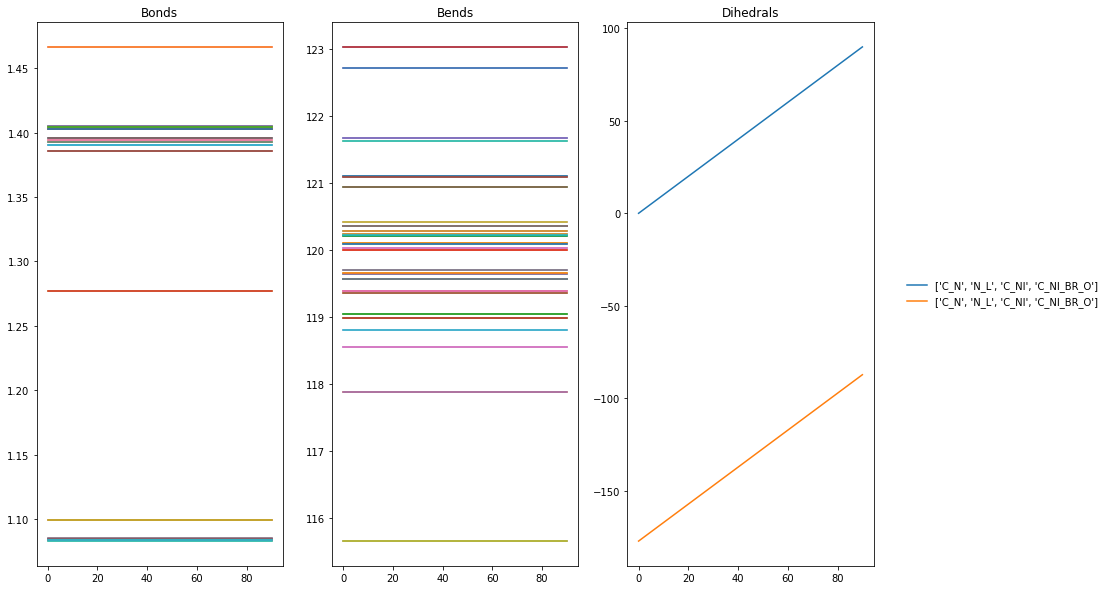

300/new_ff
300/new_ff ICs

Bonds:
Bends:
Dihedrals:
['C_HCN_C3_01-02-04', 'N1_term', 'C2_term', 'C3_term'] 0.7853981662637365
['C_HCN_C3_01-02-04', 'N1_term', 'C2_term', 'C3_term'] 0.7853981624175826





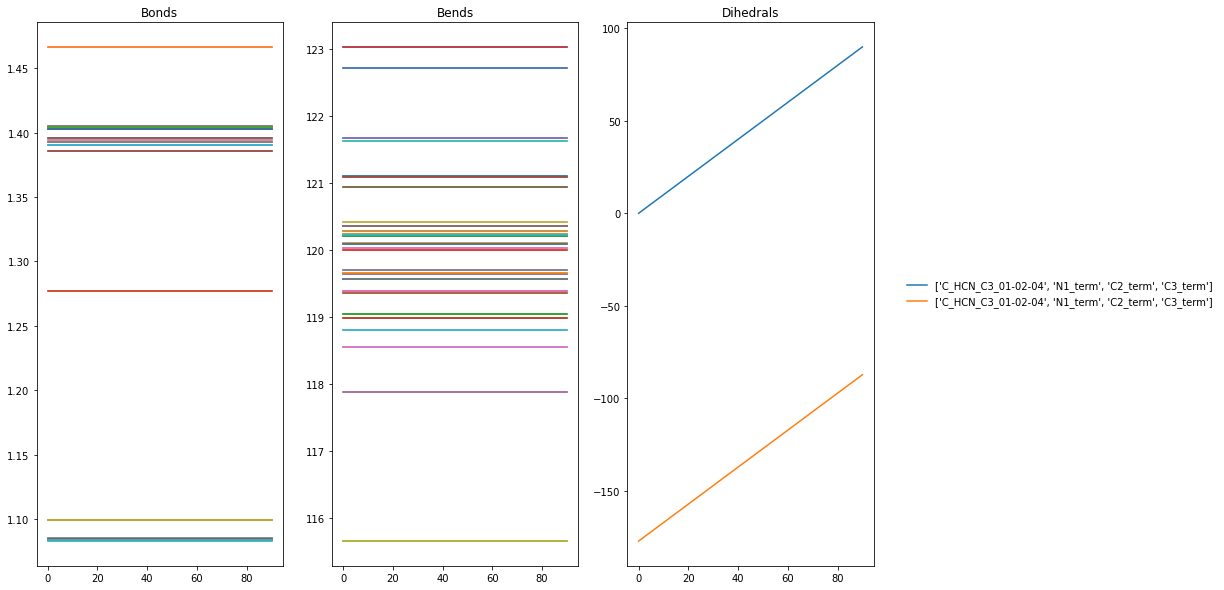

320/old_ff
320/old_ff ICs

Bonds:
Bends:
Dihedrals:
['C_N', 'N_L', 'C_NI', 'C_NI_BR_O'] 0.7853981662637365
There was no FF term for the following dihedral:  ('C_N', 'N_L', 'C_NI', 'C_NI_BR_O')
['C_N', 'N_L', 'C_NI', 'C_NI_BR_O'] 0.7853981612087912
There was no FF term for the following dihedral:  ('C_N', 'N_L', 'C_NI', 'C_NI_BR_O')





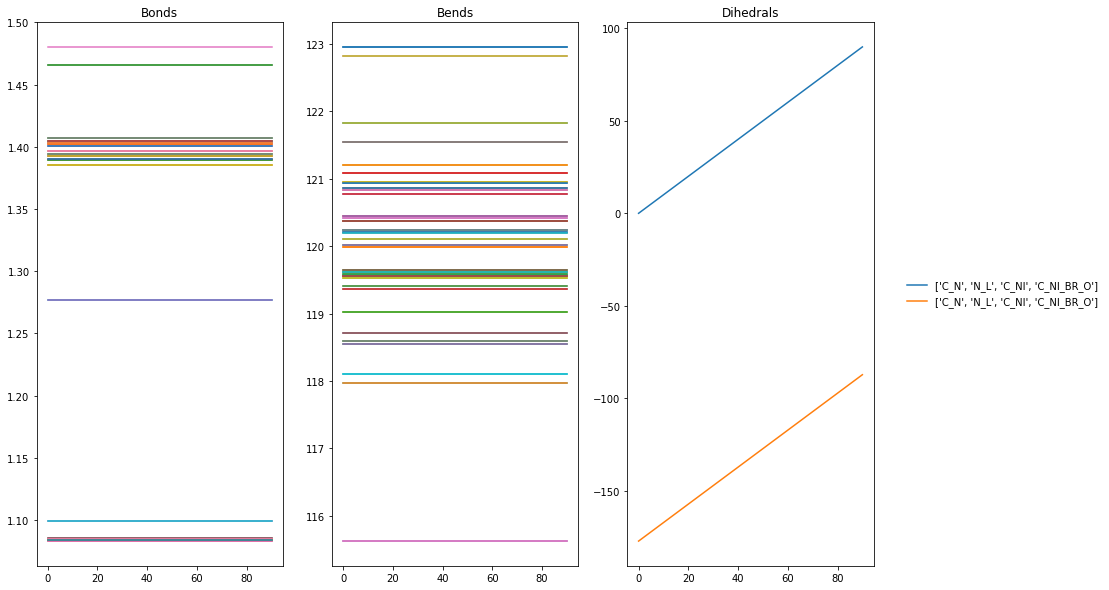

320/new_ff
320/new_ff ICs

Bonds:
Bends:
Dihedrals:
['C_HCN_C3_03-02-04', 'N1_term', 'C2_term', 'C3_term'] 0.7853981662637365
['C_HCN_C3_03-02-04', 'N1_term', 'C2_term', 'C3_term'] 0.7853981612087912





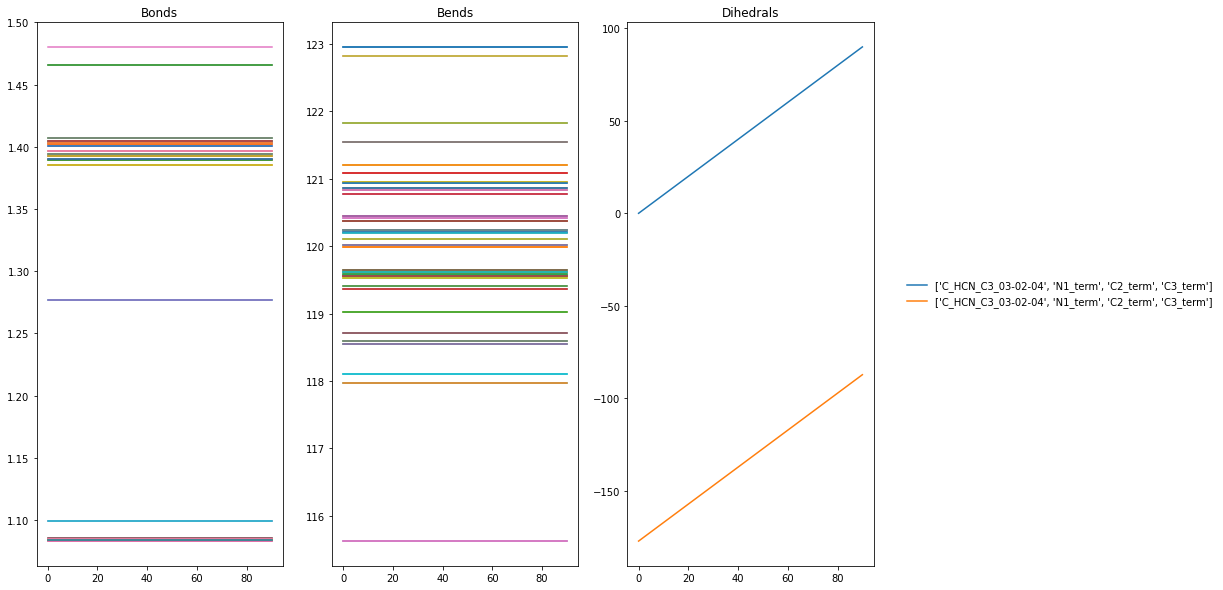

In [122]:
# First check whether only the dihedrals are changing
for name,sinfo in sinfos_cof300.items():
    plot_IC_variations(name,sinfo)

In [123]:
# Then alter the ff objects with the altered ffpars
for name,sinfo in sinfos_cof300.items():
    write_ffpars_nodih(name,sinfo)

300/old_ff ICs

Dihedrals:
['C_N', 'N_L', 'C_NI', 'C_NI_BR_O']
['C_N', 'N_L', 'C_NI', 'C_NI_BR_O']



300/new_ff ICs

Dihedrals:
['C_HCN_C3_01-02-04', 'N1_term', 'C2_term', 'C3_term']
['C_HCN_C3_01-02-04', 'N1_term', 'C2_term', 'C3_term']
Removed the following line:  TORSION:PARS   C3_term   C2_term   N1_term  C_HCN_C3_01-02-04  2 5.0683449465e+00  0.0000000000e+00



320/old_ff ICs

Dihedrals:
['C_N', 'N_L', 'C_NI', 'C_NI_BR_O']
['C_N', 'N_L', 'C_NI', 'C_NI_BR_O']



320/new_ff ICs

Dihedrals:
['C_HCN_C3_03-02-04', 'N1_term', 'C2_term', 'C3_term']
['C_HCN_C3_03-02-04', 'N1_term', 'C2_term', 'C3_term']
Removed the following line:  TORSION:PARS   C3_term   C2_term   N1_term  C_HCN_C3_03-02-04  2 5.0253091858e+00  0.0000000000e+00





In [46]:
# Perform the scans
for name,sinfo in sinfos_cof300.items():
    print(name)
    pr_sub = Project(sinfo.get_sub_project_name(name))
    grid = np.arange(sinfo.range_min, sinfo.range_max+sinfo.range_step, sinfo.range_step)
    for n,val in enumerate(grid):
        adapted_structure = sinfo.adapt_structure(sinfo.ff.structure,val)
        g16_job(pr_sub,adapted_structure,'job_{}'.format(n),run_time=1*60*60)

300_new
This group does not exist in the HDF5 file job_0


/scratch/gent/419/vsc41947/nanoscale/anaconda3/envs/pysqa/lib/python3.7/site-packages/pyiron/gaussian/gaussian.py:593: UserWarning: You can only use the EmpiricalDispersion option with a "high" verbosity. This has been automatically updated.
  warnings.warn('You can only use the EmpiricalDispersion option with a "high" verbosity. This has been automatically updated.')


The job job_0 was saved and received the ID: 59781
Queue system id:  452394173
This group does not exist in the HDF5 file job_1
The job job_1 was saved and received the ID: 59782
Queue system id:  452394183
This group does not exist in the HDF5 file job_2
The job job_2 was saved and received the ID: 59783
Queue system id:  452394193
This group does not exist in the HDF5 file job_3
The job job_3 was saved and received the ID: 59784
Queue system id:  452394203
This group does not exist in the HDF5 file job_4
The job job_4 was saved and received the ID: 59785
Queue system id:  452394213
This group does not exist in the HDF5 file job_5
The job job_5 was saved and received the ID: 59786
Queue system id:  452394223
This group does not exist in the HDF5 file job_6
The job job_6 was saved and received the ID: 59787
Queue system id:  452394233
This group does not exist in the HDF5 file job_7
The job job_7 was saved and received the ID: 59788
Queue system id:  452394243
This group does not exist

Queue system id:  452394803
This group does not exist in the HDF5 file job_64
The job job_64 was saved and received the ID: 59845
Queue system id:  452394813
This group does not exist in the HDF5 file job_65
The job job_65 was saved and received the ID: 59846
Queue system id:  452394823
This group does not exist in the HDF5 file job_66
The job job_66 was saved and received the ID: 59847
Queue system id:  452394833
This group does not exist in the HDF5 file job_67
The job job_67 was saved and received the ID: 59848
Queue system id:  452394843
This group does not exist in the HDF5 file job_68
The job job_68 was saved and received the ID: 59849
Queue system id:  452394853
This group does not exist in the HDF5 file job_69
The job job_69 was saved and received the ID: 59850
Queue system id:  452394863
This group does not exist in the HDF5 file job_70
The job job_70 was saved and received the ID: 59851
Queue system id:  452394873
This group does not exist in the HDF5 file job_71
The job job_

This group does not exist in the HDF5 file job_36
The job job_36 was saved and received the ID: 59908
Queue system id:  452395443
This group does not exist in the HDF5 file job_37
The job job_37 was saved and received the ID: 59909
Queue system id:  452395453
This group does not exist in the HDF5 file job_38
The job job_38 was saved and received the ID: 59910
Queue system id:  452395463
This group does not exist in the HDF5 file job_39
The job job_39 was saved and received the ID: 59911
Queue system id:  452395473
This group does not exist in the HDF5 file job_40
The job job_40 was saved and received the ID: 59912
Queue system id:  452395483
This group does not exist in the HDF5 file job_41
The job job_41 was saved and received the ID: 59913
Queue system id:  452395493
This group does not exist in the HDF5 file job_42
The job job_42 was saved and received the ID: 59914
Queue system id:  452395503
This group does not exist in the HDF5 file job_43
The job job_43 was saved and received th

In [50]:
pr7.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,59781,finished,C20H16N2,job_0,/job_0,/kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/,doctoraat/barriers/cof-300/300_new_16_17_14_13/,2022-01-13 18:03:59.007075,2022-01-13 18:06:39.748920,160.0,pyiron@gligar06.gastly.os#9#kirlia,Gaussian,0.1,None,None
116,59897,finished,C26H20N2,job_25,/job_25,/kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/,doctoraat/barriers/cof-300/320_new_40_41_38_37/,2022-01-13 19:58:02.772086,2022-01-13 20:02:53.712550,290.0,pyiron@gligar06.gastly.os#9#kirlia,Gaussian,0.1,None,None
117,59898,finished,C26H20N2,job_26,/job_26,/kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/,doctoraat/barriers/cof-300/320_new_40_41_38_37/,2022-01-13 19:58:02.754305,2022-01-13 20:02:53.678574,290.0,pyiron@gligar06.gastly.os#9#kirlia,Gaussian,0.1,None,None
118,59899,finished,C26H20N2,job_27,/job_27,/kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/,doctoraat/barriers/cof-300/320_new_40_41_38_37/,2022-01-13 19:58:31.219802,2022-01-13 20:03:16.208581,284.0,pyiron@gligar06.gastly.os#9#kirlia,Gaussian,0.1,None,None
119,59900,finished,C26H20N2,job_28,/job_28,/kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/,doctoraat/barriers/cof-300/320_new_40_41_38_37/,2022-01-13 20:03:31.608313,2022-01-13 20:08:16.820356,285.0,pyiron@gligar06.gastly.os#9#kirlia,Gaussian,0.1,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,59844,finished,C20H16N2,job_63,/job_63,/kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/,doctoraat/barriers/cof-300/300_new_16_17_14_13/,2022-01-13 18:43:50.832300,2022-01-13 18:46:31.903695,161.0,pyiron@gligar06.gastly.os#9#kirlia,Gaussian,0.1,None,None
64,59845,finished,C20H16N2,job_64,/job_64,/kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/,doctoraat/barriers/cof-300/300_new_16_17_14_13/,2022-01-13 18:46:17.323186,2022-01-13 18:48:54.235933,156.0,pyiron@gligar06.gastly.os#9#kirlia,Gaussian,0.1,None,None
65,59846,finished,C20H16N2,job_65,/job_65,/kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/,doctoraat/barriers/cof-300/300_new_16_17_14_13/,2022-01-13 18:46:50.005694,2022-01-13 18:49:32.399474,162.0,pyiron@gligar06.gastly.os#9#kirlia,Gaussian,0.1,None,None
67,59848,finished,C20H16N2,job_67,/job_67,/kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/,doctoraat/barriers/cof-300/300_new_16_17_14_13/,2022-01-13 18:49:18.461170,2022-01-13 18:51:55.813414,157.0,pyiron@gligar06.gastly.os#9#kirlia,Gaussian,0.1,None,None


## AI barrier data parsing

### Functions

In [102]:
# Gather AI data for each project with pyiron table

def cluster_pos(positions, rvecs, indices):
    import itertools
    pos = copy.copy(positions)
    a,b,c = rvecs[0], rvecs[1], rvecs[2]
    for n in indices[1:]:
        images = pos[n] + np.array([sum(n * vec for n, vec in zip(ns, [a,b,c])) for ns in itertools.product([-1,0,1],repeat=3)]) # 3 dimensions
        distances = np.linalg.norm(images-pos[indices[0]], axis=-1)
        pos[n] = images[np.argmin(distances)]
    return pos

def normal(v1,v2):
    n = np.cross(v1,v2, axis=-1)
    return (n.T/np.linalg.norm(n,axis=-1)).T

def get_dihedral(job,indices,cluster=True):
    pos = job['output/generic/positions']

    # If an optimization happened, pbc might have moved atoms, only consider final frame
    if cluster and pos.shape[0]>1:
        pos = cluster_pos(pos[-1,:,:], job['output/generic/cells'][-1,:,:], indices).reshape(1,-1,3)

    i1,i2,i3,i4 = indices
    n1 = normal(pos[:,i2,:] - pos[:,i1,:], pos[:,i3,:] - pos[:,i2,:])
    n2 = normal(pos[:,i3,:] - pos[:,i2,:], pos[:,i4,:] - pos[:,i3,:])
    phi = np.arccos(np.einsum('ij,ij->i',n1,n2))
    signs = np.sign(np.einsum('ij,ij->i',n1,pos[:,i4,:] - pos[:,i3,:]))
    phi *= signs

    return phi

def get_e(job):
    energy = job['output/generic/energy_tot']*electronvolt
    if isinstance(energy,np.ndarray):
        return energy[-1]
    else:
        return energy

def get_table(pr,name,grid,sinfo):
    # Create table
    name = name.translate({ord(c): None for c in '!@#$(),/'})
    table = pr.create_table('table_'+name, delete_existing_job=True)
    
    def db_filter(job_table):
        return (job_table.status == "finished") & (job_table.hamilton != 'TableJob') & (job_table.job.str.contains('job_', regex=False))
    
    #def get_angle(job,indices=indices):
    #    return 
    #    #return grid[int(job.job_name.split('_')[1])] # in degrees
    
    table.db_filter_function = db_filter
    #table.convert_to_object = True  
    
    # Introduce property function
    if sinfo.fit_indices is not None:
        indices = sinfo.fit_indices
        ref_indices = sinfo.indices
        table.add["reference_angle"] = lambda job: get_dihedral(job,ref_indices)[-1]/deg
    else:
        indices = sinfo.indices
        
    table.add["angle"] = lambda job: get_dihedral(job,indices)[-1]/deg   
    table.add["E"] = get_e

    # Run it
    table.run()

    # Get the dataframe
    return table.get_dataframe()

# Plotting function
def plot(name,aid):
    print(name)
    fig,ax = pt.subplots(1,2,sharey=True,figsize=(25,5))
    
    angles = aid.sort_values(by=['angle']).angle
    energy = aid.sort_values(by=['angle']).E/kjmol

    ax[0].plot(angles,energy, 'bo--')
    ax[0].set_xlabel(u'Dihedral angle (°)')
    ax[0].set_ylabel('E (kJ/mol)')
    ax[0].set_xlim([min(angles), max(angles)])


    xc = np.cos(np.deg2rad(angles))
    yc = energy[xc.argsort()]
    xc = xc[xc.argsort()]

    ax[1].plot(xc,yc,'bo--')
    ax[1].set_xlabel(u'cos $\phi$')
    #ax[1].set_ylabel('E (kJ/mol)')
    ax[1].set_xlim([min(xc), max(xc)])
    ax[1].axvline(0,0,100,c='k')
    pt.show()

### COF-300

In [124]:
# Gather data
ai_data_cof300 = {}
for name,sinfo in sinfos_cof300.items():
    pr_name = name.split('/')[0]+'_'+name.split('/')[1].split('_')[0]
    if 'old' in pr_name:
        continue
    print(sinfo.get_sub_project_name(pr_name))
    pr_sub = Project(sinfo.get_sub_project_name(pr_name))
    grid = np.arange(sinfo.range_min, sinfo.range_max+sinfo.range_step, sinfo.range_step)
    ai_data_cof300[name] = get_table(pr_sub,pr_name,grid,sinfo)

for name,sinfo in sinfos_cof300.items():
    if 'old' in name:
        new_name = name.split('/')[0]+'/new_ff'
        ai_data_cof300[name] = ai_data_cof300[new_name]

barriers/cof-300/300_new_16_17_14_13
The job table_300_new was saved and received the ID: 59985


100%|██████████| 91/91 [00:00<00:00, 105.30it/s]
2022-01-14 11:09:21,694 - pyiron_log - WARNING - The job table_300_new is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


barriers/cof-300/320_new_40_41_38_37
The job table_320_new was saved and received the ID: 59986


100%|██████████| 91/91 [00:00<00:00, 94.45it/s]
2022-01-14 11:09:23,420 - pyiron_log - WARNING - The job table_320_new is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


300/new_ff


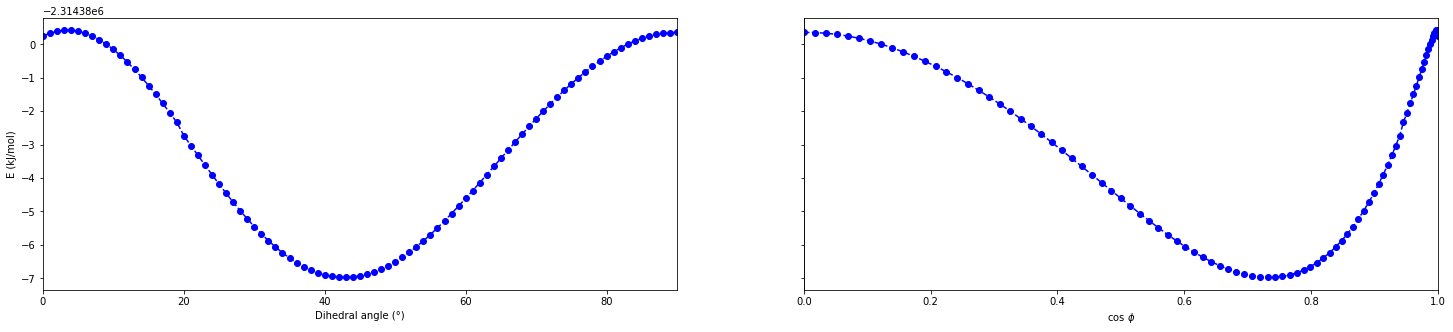

320/new_ff


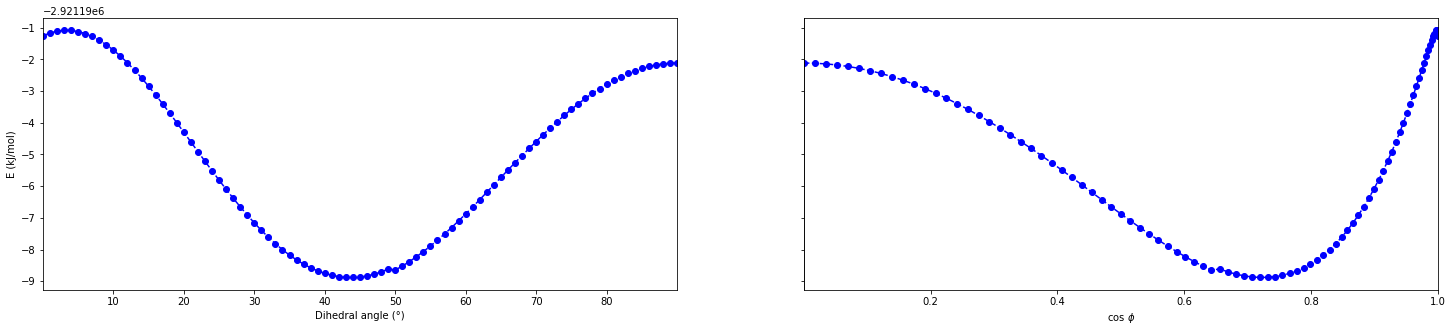

300/old_ff


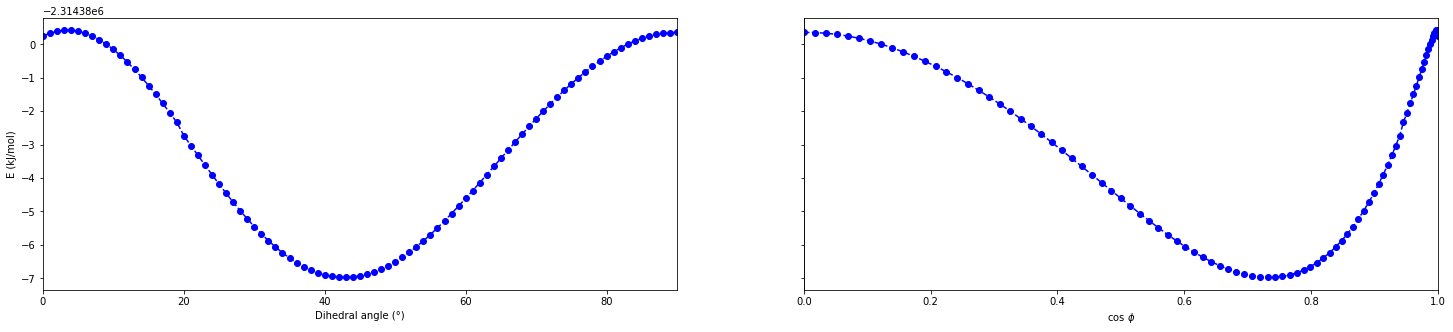

320/old_ff


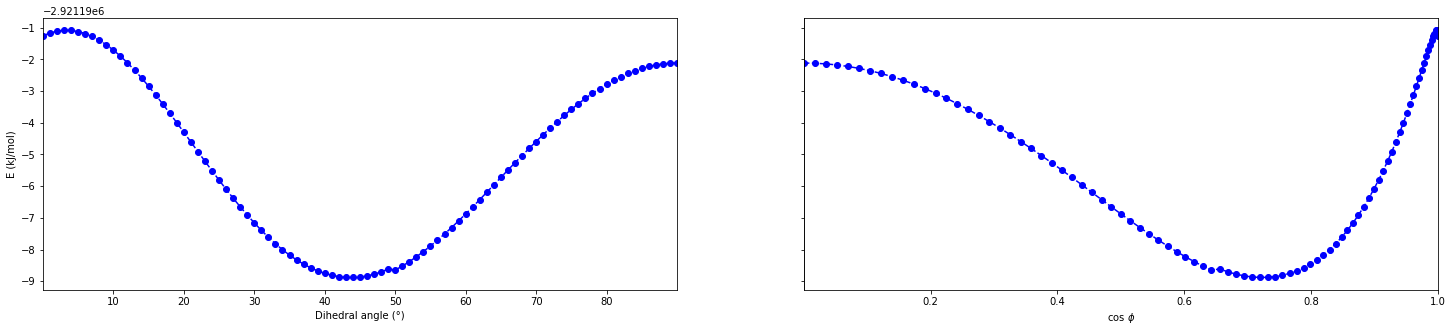

In [125]:
# Plotting
for name,aid in ai_data_cof300.items():
    plot(name,aid)

## FF barrier data calculation

### COF-300

In [126]:
# Perform the scans
for name,sinfo in sinfos_cof300.items():
    pr_name = name.split('/')[0]+'_'+name.split('/')[1].split('_')[0]
    yaff_scan_job(sinfo.pr, 'scan_'+pr_name+'_nodih', sinfo, sinfo.ff.ffpars_nodih)
    yaff_scan_job(sinfo.pr, 'scan_'+pr_name+'_wdih', sinfo, sinfo.ff.ffpars)

The job scan_300_old_nodih was saved and received the ID: 59987
Queue system id:  130470770
The job scan_300_old_wdih was saved and received the ID: 59988
Queue system id:  130470780
The job scan_300_new_nodih was saved and received the ID: 59989
Queue system id:  130470790
The job scan_300_new_wdih was saved and received the ID: 59990
Queue system id:  130470800
This group does not exist in the HDF5 file scan_320_old_nodih
The job scan_320_old_nodih was saved and received the ID: 59991
Queue system id:  130470810
This group does not exist in the HDF5 file scan_320_old_wdih
The job scan_320_old_wdih was saved and received the ID: 59992
Queue system id:  130470820
The job scan_320_new_nodih was saved and received the ID: 59993
Queue system id:  130470830
The job scan_320_new_wdih was saved and received the ID: 59994
Queue system id:  130470840


In [136]:
pr7.job_table(recursive=False)

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,59971,finished,C20H16N2,scan_300_new_polysix,/scan_300_new_polysix,/kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/,doctoraat/barriers/cof-300/,2022-01-14 10:19:34.407366,2022-01-14 10:19:42.160111,7.0,pyiron@gligar06.gastly.os#1#victini,Yaff,0.1,None,None
1,59972,finished,C26H20N2,scan_320_new_polysix,/scan_320_new_polysix,/kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/,doctoraat/barriers/cof-300/,2022-01-14 10:19:43.424562,2022-01-14 10:19:51.036182,7.0,pyiron@gligar06.gastly.os#1#victini,Yaff,0.1,None,None
2,59987,finished,C20H16N2,scan_300_old_nodih,/scan_300_old_nodih,/kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/,doctoraat/barriers/cof-300/,2022-01-14 11:09:49.383313,2022-01-14 11:09:57.180836,7.0,pyiron@gligar06.gastly.os#1#victini,Yaff,0.1,None,None
3,59988,finished,C20H16N2,scan_300_old_wdih,/scan_300_old_wdih,/kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/,doctoraat/barriers/cof-300/,2022-01-14 11:09:52.737511,2022-01-14 11:10:01.398904,8.0,pyiron@gligar06.gastly.os#1#victini,Yaff,0.1,None,None
4,59989,finished,C20H16N2,scan_300_new_nodih,/scan_300_new_nodih,/kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/,doctoraat/barriers/cof-300/,2022-01-14 11:10:00.020787,2022-01-14 11:10:08.438798,8.0,pyiron@gligar06.gastly.os#1#victini,Yaff,0.1,None,None
5,59990,finished,C20H16N2,scan_300_new_wdih,/scan_300_new_wdih,/kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/,doctoraat/barriers/cof-300/,2022-01-14 11:10:05.575001,2022-01-14 11:10:14.486057,8.0,pyiron@gligar06.gastly.os#1#victini,Yaff,0.1,None,None
6,59991,finished,C26H20N2,scan_320_old_nodih,/scan_320_old_nodih,/kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/,doctoraat/barriers/cof-300/,2022-01-14 11:10:10.497628,2022-01-14 11:10:20.353004,9.0,pyiron@gligar06.gastly.os#1#victini,Yaff,0.1,None,None
7,59992,finished,C26H20N2,scan_320_old_wdih,/scan_320_old_wdih,/kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/,doctoraat/barriers/cof-300/,2022-01-14 11:10:18.665103,2022-01-14 11:10:26.152977,7.0,pyiron@gligar06.gastly.os#1#victini,Yaff,0.1,None,None
8,59993,finished,C26H20N2,scan_320_new_nodih,/scan_320_new_nodih,/kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/,doctoraat/barriers/cof-300/,2022-01-14 11:10:25.416013,2022-01-14 11:10:34.158328,8.0,pyiron@gligar06.gastly.os#1#victini,Yaff,0.1,None,None
9,59994,finished,C26H20N2,scan_320_new_wdih,/scan_320_new_wdih,/kyukon/scratch/gent/vo/000/gvo00003/vsc41947/pyiron/projects/,doctoraat/barriers/cof-300/,2022-01-14 11:10:30.870510,2022-01-14 11:10:44.813999,13.0,pyiron@gligar06.gastly.os#1#victini,Yaff,0.1,None,None


## FF barrier data parsing

### Functions

In [58]:
@dataclass
class FF_data:
    table_nodih: object
    table_wdih: object
    table_polysix: object

In [114]:
import pandas as pd

def get_tables_ff(name,sinfo,grid):   
    nodih = sinfo.pr.load('scan_'+name+'_nodih')
    wdih = sinfo.pr.load('scan_'+name+'_wdih')
    
    if nodih is not None:
        epot_contrib_names = [contrib_name.decode("utf-8") for contrib_name in nodih['output/generic/epot_contrib_names']]
    else:
        epot_contrib_names = [contrib_name.decode("utf-8") for contrib_name in wdih['output/generic/epot_contrib_names']]
    
    if sinfo.fit_indices is not None:
        angles = get_dihedral(nodih,sinfo.fit_indices,cluster=False)/deg
    else:
        angles = get_dihedral(nodih,sinfo.indices,cluster=False)/deg
    df_nodih = pd.DataFrame(np.array([angles,*nodih['output/generic/epot_contribs'].T*electronvolt,nodih['output/generic/energy_pot']*electronvolt]).T,
                   columns=['angle', *epot_contrib_names, 'e_tot'])
    df_wdih = pd.DataFrame(np.array([angles,*wdih['output/generic/epot_contribs'].T*electronvolt,wdih['output/generic/energy_pot']*electronvolt]).T,
                   columns=['angle', *epot_contrib_names, 'e_tot'])

    # Get the dataframe
    return df_nodih, df_wdih

def get_table_polysix(name,sinfo,grid):
    polysix = sinfo.pr.load('scan_'+name+'_polysix')
    if sinfo.fit_indices is not None:
        angles = get_dihedral(polysix,sinfo.fit_indices,cluster=False)/deg
    else:
        angles = get_dihedral(polysix,sinfo.indices,cluster=False)/deg
    return pd.DataFrame(np.array([angles,polysix['output/generic/energy_pot']*electronvolt]).T,
                   columns=['angle', 'e_tot'])

def centre(arr):
    return (arr-np.nanmin(arr))

# Plotting and fitting function
def fit_and_plot_ff(name,sinfo,aid,ffd,save_png=False):
    from scipy import optimize

    print(name)
    odd = True # will select correct poly function
    
    vdw_names = ['pair_mm3','pair_lj','pair_mm3cap']
    if len(ffd.table_nodih)>0:
        vdw_name = [name for name in vdw_names if name in list(ffd.table_nodih.columns)]
    else:
        vdw_name = [name for name in vdw_names if name in list(ffd.table_wdih.columns)]
    assert len(vdw_name)==1
    vdw_name = vdw_name[0]
    
    
    # FF data
    if len(ffd.table_nodih)>0:
        angles       = ffd.table_nodih.sort_values(by=['angle']).angle
        FF_val_nodih = ffd.table_nodih.sort_values(by=['angle']).valence/kjmol
        FF_ei_nodih  = ffd.table_nodih.sort_values(by=['angle']).pair_ei/kjmol
        FF_vdw_nodih = ffd.table_nodih.sort_values(by=['angle'])[vdw_name]/kjmol
        FF_tot_nodih = ffd.table_nodih.sort_values(by=['angle']).e_tot/kjmol
        
    else:
        angles       = ffd.table_wdih.sort_values(by=['angle']).angle
    
    FF_val_wdih = ffd.table_wdih.sort_values(by=['angle']).valence/kjmol
    FF_ei_wdih  = ffd.table_wdih.sort_values(by=['angle']).pair_ei/kjmol
    FF_vdw_wdih = ffd.table_wdih.sort_values(by=['angle'])[vdw_name]/kjmol
    FF_tot_wdih = ffd.table_wdih.sort_values(by=['angle']).e_tot/kjmol
    
    # AI data
    if aid is not None:
        ai_angles   = aid.sort_values(by=['angle']).angle
        ai_energy   = aid.sort_values(by=['angle']).E/kjmol
        try:
            assert np.all(np.isclose(np.asarray(ai_angles),np.asarray(angles),atol=1e-5))
        except AssertionError:
            print(np.asarray(ai_angles),np.asarray(angles))
            raise AssertionError
    
    
    # If angle range is limited to 90 degrees mirror the behaviour to 180
    def mirror(array, angle=False):
        if angle:
            return np.hstack((array, 180-array[:-1][::-1]))
        else:
            return np.hstack((array, array[:-1][::-1]))
        
    if np.isclose(np.max(angles),90,atol=1e-5):
        print('Mirroring')
        odd = False
        angles       = mirror(angles,angle=True)
        if len(ffd.table_nodih)>0:
            FF_val_nodih = mirror(FF_val_nodih)
            FF_ei_nodih  = mirror(FF_ei_nodih)
            FF_vdw_nodih = mirror(FF_vdw_nodih)
            FF_tot_nodih = mirror(FF_tot_nodih)
        
        FF_val_wdih = mirror(FF_val_wdih)
        FF_ei_wdih  = mirror(FF_ei_wdih)
        FF_vdw_wdih = mirror(FF_vdw_wdih)
        FF_tot_wdih = mirror(FF_tot_wdih)
        
        if aid is not None:
            ai_energy   = mirror(ai_energy)
    else:
        angles      = np.asarray(angles)
        
        if len(ffd.table_nodih)>0:
            FF_val_nodih = np.asarray(FF_val_nodih)
            FF_ei_nodih  = np.asarray(FF_ei_nodih)
            FF_vdw_nodih = np.asarray(FF_vdw_nodih)
            FF_tot_nodih = np.asarray(FF_tot_nodih)
        
        FF_val_wdih = np.asarray(FF_val_wdih)
        FF_ei_wdih  = np.asarray(FF_ei_wdih)
        FF_vdw_wdih = np.asarray(FF_vdw_wdih)
        FF_tot_wdih = np.asarray(FF_tot_wdih)
        
        if aid is not None:
            ai_energy   = np.asarray(ai_energy)
        
    def get_poly(odd):
        # Fit functions
        def poly(x,b,d,f,g):
            return g + b*x**2 + d*x**4 + f*x**6

        def poly_odd(x,a,b,c,d,e,f,g):
            return g + a*x + b*x**2 + c*x**3 + d*x**4 + e*x**5 + f*x**6
        
        if odd:
            return poly_odd
        else:
            return poly
        
    fpoly = get_poly(odd)
    
    if aid is not None:
        # Calculate difference and fit a polysix term to the difference, focussing on the minimum
        diff = centre(ai_energy - FF_tot_nodih)

        cosr = np.cos(np.deg2rad(angles)) # range as cos(x)
        fitr = cosr[~np.isnan(diff)]
        fitf = diff[~np.isnan(diff)]

        sigma=np.ones(len(fitf))
        #sigma[np.argmin(fitf)] = 1e-4 # force minimum position
        #sigma[centre(ai_energy)<20*kjmol] = 1e-4
        p,pcov = optimize.curve_fit(fpoly, fitr, fitf, sigma=sigma)
        print(p)


        # Plot FF and AI data and compare with fit
        fig,ax = pt.subplots(2,2,sharex=True,sharey=True,figsize=(25,10))
        ax[0,0].plot(angles,centre(FF_val_nodih), label='valence')
        ax[0,0].plot(angles,centre(FF_ei_nodih), label='ei')
        ax[0,0].plot(angles,centre(FF_vdw_nodih), label='vdw')
        ax[0,0].plot(angles,centre(FF_tot_nodih), ls='--', label='tot')
        ax[0,0].plot(angles,centre(ai_energy), label='AI')
        ax[0,0].set_xlabel(r'$\psi$ ($^\circ$)')
        ax[0,0].set_ylabel('E (kJ/mol)')
        ax[0,0].legend(bbox_to_anchor=(1.0,.5), loc=6)
        ax[0,0].set_title('Energy barrier wo dihedral term')

        ax[0,1].plot(angles,centre(FF_val_wdih), label='valence')
        ax[0,1].plot(angles,centre(FF_ei_wdih), label='ei')
        ax[0,1].plot(angles,centre(FF_vdw_wdih), label='vdw')
        ax[0,1].plot(angles,centre(FF_tot_wdih), ls='--', label='tot')
        ax[0,1].plot(angles,centre(ai_energy), label='AI')
        ax[0,1].set_xlabel(r'$\psi$ ($^\circ$)')
        ax[0,1].set_ylabel('E (kJ/mol)')
        ax[0,1].legend(bbox_to_anchor=(1.0,.5), loc=6)
        ax[0,1].set_title('Energy barrier w dihedral term')

        ax[1,0].plot(angles,diff, c='r', label='diff')
        ax[1,0].plot(angles,fpoly(cosr,*p), 'k--', label='fit')
        ax[1,0].set_xlabel(r'$\psi$ ($^\circ$)')
        ax[1,0].set_ylabel('E (kJ/mol)')
        ax[1,0].legend(bbox_to_anchor=(1.0,.5), loc=6)
        ax[1,0].set_title('Fit (wrt diff)')

        ax[1,1].plot(angles,centre(ai_energy), label='AI', c='r')
        ax[1,1].plot(angles,centre(fpoly(cosr,*p) + FF_tot_nodih), 'k--',label='fit')
        ax[1,1].set_xlabel(r'$\psi$ ($^\circ$)')
        ax[1,1].set_ylabel('E (kJ/mol)')
        ax[1,1].legend(bbox_to_anchor=(1.0,.5), loc=6)
        ax[1,1].set_title('Fit (wrt AI barrier)')
        
        '''
        ax[2,0].plot(cosr,diff, c='r', label='diff')
        ax[2,0].plot(cosr,fpoly(cosr,*p), 'k--', label='fit')
        ax[2,0].set_xlabel(r'$\cos \psi$')
        ax[2,0].set_ylabel('E (kJ/mol)')
        ax[2,0].legend(bbox_to_anchor=(1.0,.5), loc=6)
        ax[2,0].set_title('Fit (wrt diff)')

        ax[2,1].plot(cosr,centre(ai_energy), label='AI', c='r')
        ax[2,1].plot(cosr,centre(fpoly(cosr,*p) + FF_tot_nodih), 'k--',label='fit')
        ax[2,1].set_xlabel(r'$\cos \psi$ ($^\circ$)')
        ax[2,1].set_ylabel('E (kJ/mol)')
        ax[2,1].legend(bbox_to_anchor=(1.0,.5), loc=6)
        ax[2,1].set_title('Fit (wrt AI barrier)')
        '''
        
    else:
        # Plot FF and AI data and compare with fit
        if len(ffd.table_nodih)>0:
            fig,ax = pt.subplots(1,2,sharex=True,sharey=True,figsize=(30,10))
            ax[0].plot(angles,centre(FF_val_nodih), label='valence')
            ax[0].plot(angles,centre(FF_ei_nodih), label='ei')
            ax[0].plot(angles,centre(FF_vdw_nodih), label='vdw')
            ax[0].plot(angles,centre(FF_tot_nodih), ls='--', label='tot')
            ax[0].set_xlabel(r'$\psi$ ($^\circ$)')
            ax[0].set_ylabel('E (kJ/mol)')
            ax[0].legend(bbox_to_anchor=(1.0,.5), loc=6)
            ax[0].set_title('Energy barrier wo dihedral term')

            ax[1].plot(angles,centre(FF_val_wdih), label='valence')
            ax[1].plot(angles,centre(FF_ei_wdih), label='ei')
            ax[1].plot(angles,centre(FF_vdw_wdih), label='vdw')
            ax[1].plot(angles,centre(FF_tot_wdih), ls='--', label='tot')
            ax[1].set_xlabel(r'$\psi$ ($^\circ$)')
            ax[1].set_ylabel('E (kJ/mol)')
            ax[1].legend(bbox_to_anchor=(1.0,.5), loc=6)
            ax[1].set_title('Energy barrier w dihedral term')
        else:
            fig,ax = pt.subplots(1,1,sharex=True,sharey=True,figsize=(30,10))
            ax.plot(angles,centre(FF_val_wdih), label='valence')
            ax.plot(angles,centre(FF_ei_wdih), label='ei')
            ax.plot(angles,centre(FF_vdw_wdih), label='vdw')
            ax.plot(angles,centre(FF_tot_wdih), ls='--', label='tot')
            ax.set_xlabel(r'$\psi$ ($^\circ$)')
            ax.set_ylabel('E (kJ/mol)')
            ax.legend(bbox_to_anchor=(1.0,.5), loc=6)
            ax.set_title('Energy barrier w dihedral term')

    
    if save_png:
        path = sinfo.pr.root_path +  sinfo.pr.project_path.split('/')[0] + '/input_files/' + '/'.join(sinfo.pr.project_path.split('/')[1:]) + sinfo.ff.block_name + '/fits/'
        pathlib.Path(path).mkdir(parents=True, exist_ok=True) # make directory if it does not exist
        pt.savefig(path+'{}.pdf'.format(name),bbox_inches='tight')
    
    pt.show()
    
    if aid is not None:
        return p

### COF-300

In [137]:
# Gather data
ff_cof300_datas = {}

# table_polysix will be calculated in 6: Testing polysix terms 
for name,sinfo in sinfos_cof300.items():
    pr_name = name.split('/')[0]+'_'+name.split('/')[1].split('_')[0]
    grid = np.arange(sinfo.range_min, sinfo.range_max+sinfo.range_step, sinfo.range_step)
    ff_cof300_datas[name] = FF_data(*get_tables_ff(pr_name,sinfo,grid),None)

300_old
Mirroring
[-33.8264366   23.44947733 -15.02785508  25.58455673]


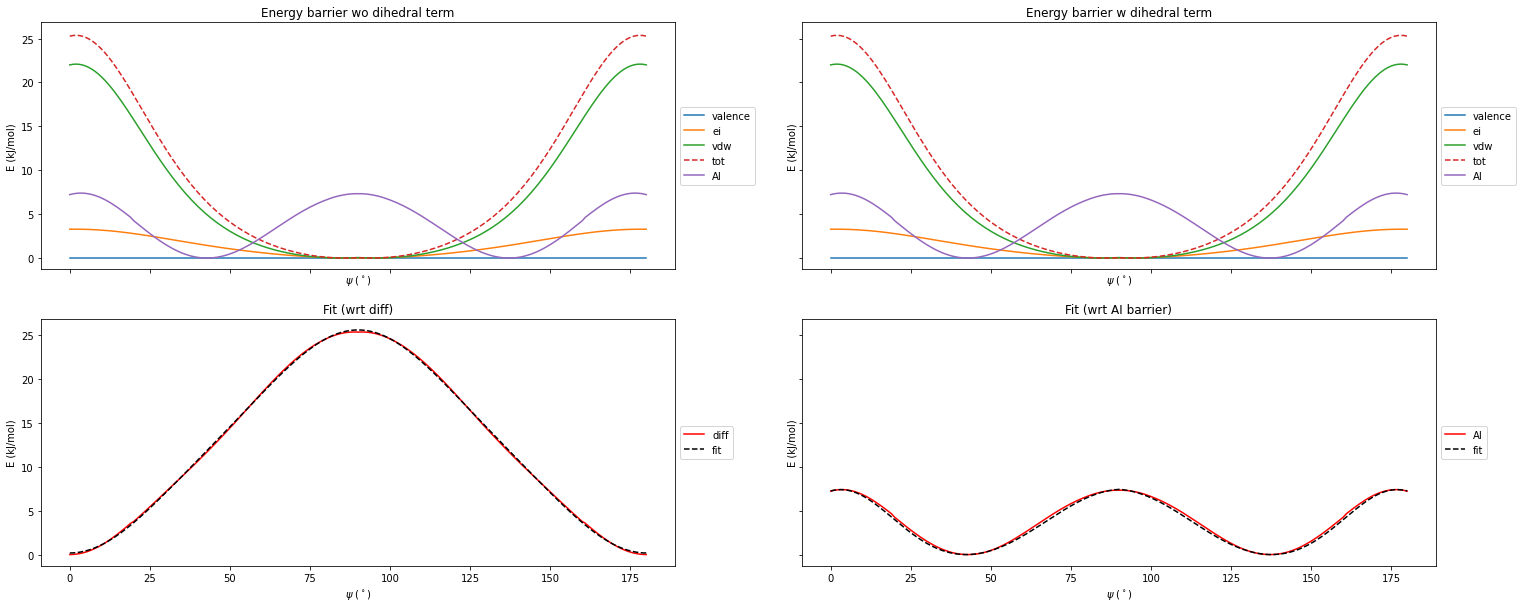

300_new
Mirroring
[-33.88226362  23.02291208 -14.93079884  25.98601372]


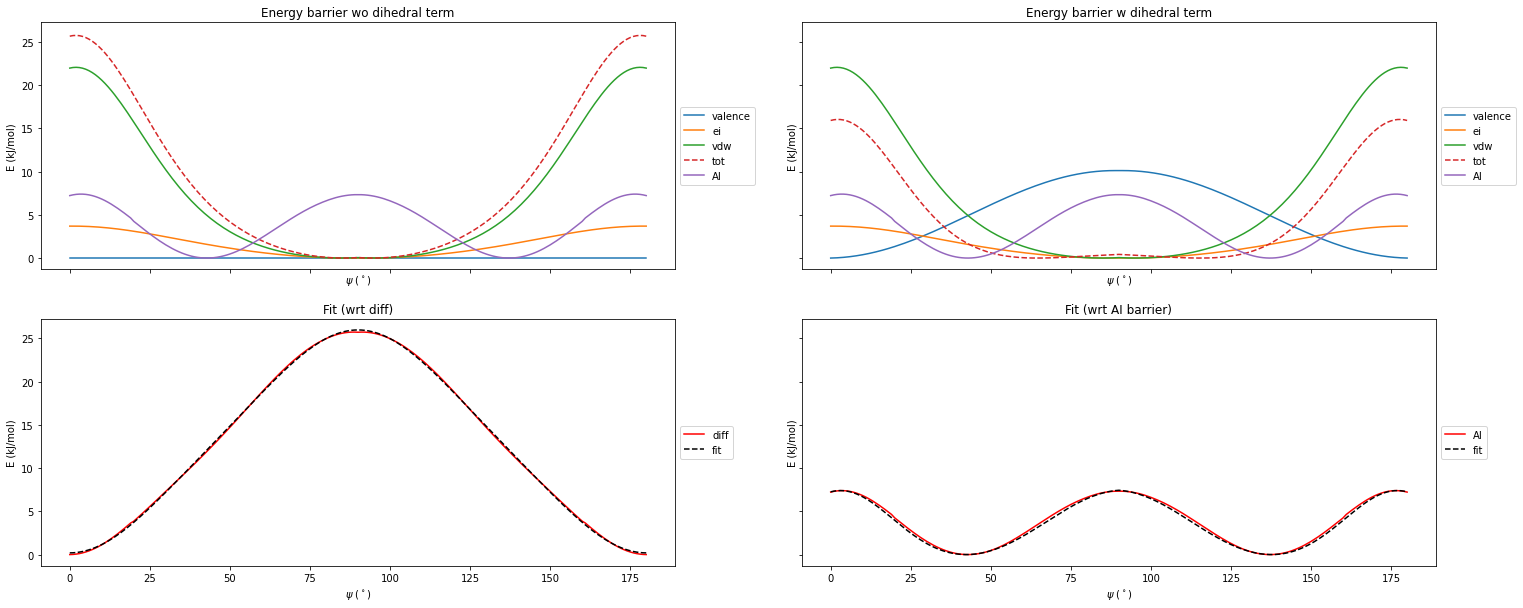

320_old
Mirroring
[-33.34394897  25.22716722 -16.70662208  24.96842081]


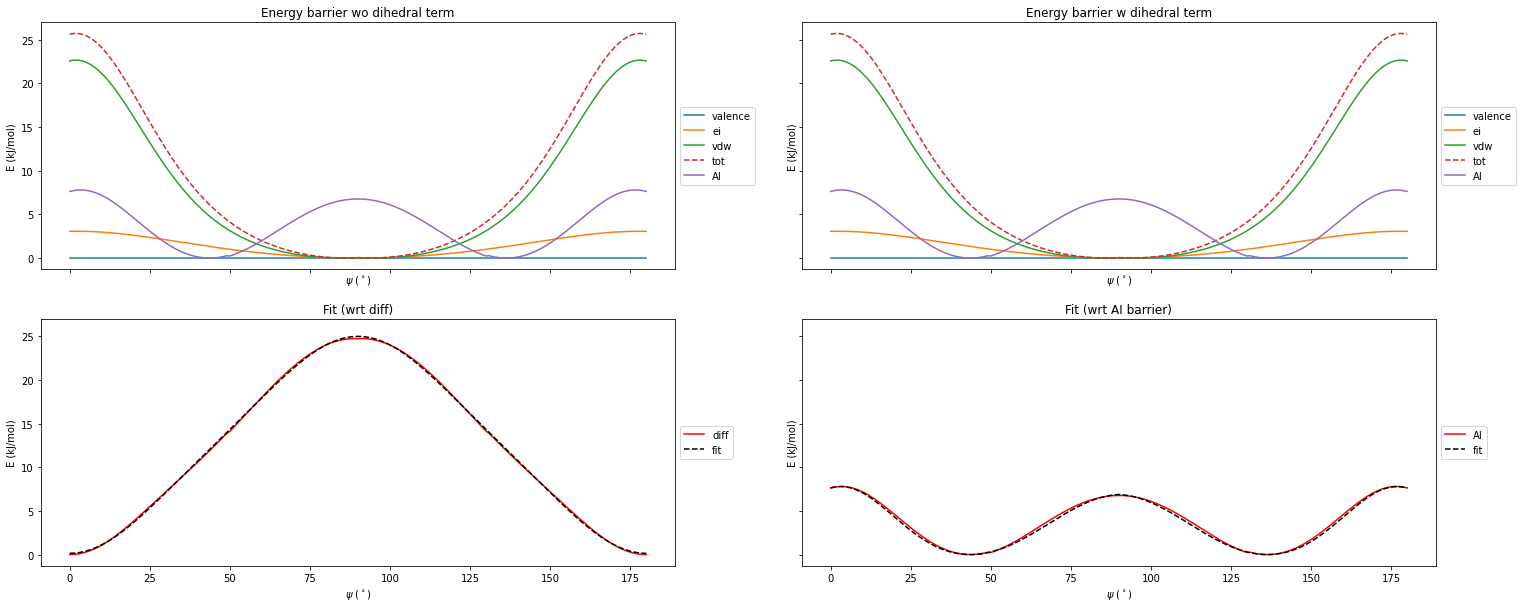

320_new
Mirroring
[-33.72394315  25.71116833 -16.94074988  25.09860761]


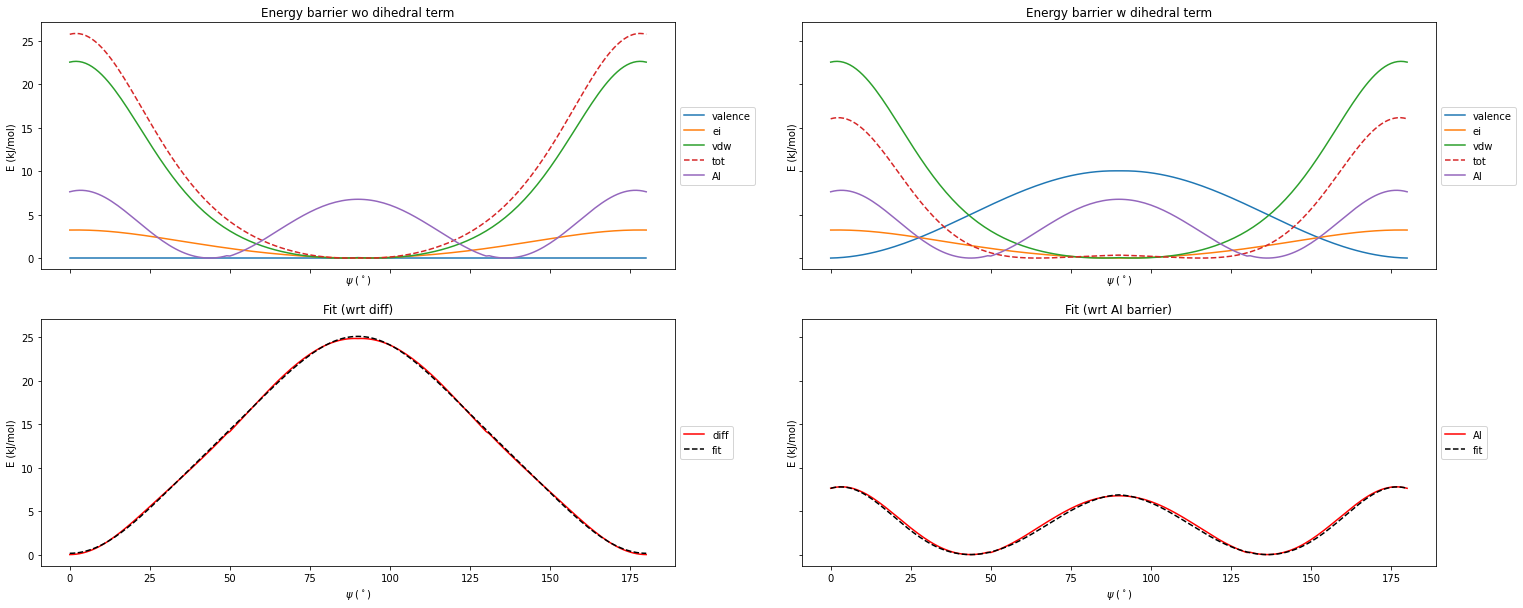

In [138]:
# Fitting and Plotting
ps_cof300 = {}
for name,ffd in ff_cof300_datas.items():
    pr_name = name.split('/')[0]+'_'+name.split('/')[1].split('_')[0]
    ps_cof300[name] = fit_and_plot_ff(pr_name,sinfos_cof300[name],ai_data_cof300[name],ffd,save_png=True)

## Generating polysix parameterfile

### Functions

In [80]:
import pathlib

def write_ffpars_polysix(sinfo,fit_params,name=None,subname=None,strict_indices=False,ref_val=0,override_degeneracy=None):    
    # Make yaff system and adapt it to angle 0
    adapted_structure = sinfo.adapt_structure(sinfo.ff.structure,ref_val)
    yaff_system = System(sinfo.ff.structure.numbers, adapted_structure.positions, ffatypes=sinfo.ff.ffatypes, ffatype_ids=sinfo.ff.ffatype_ids, bonds=sinfo.ff.bonds)
    
    # Log all dihedrals
    dihs = []
    dihs_ids = []
    dihs_cos = []
    for dih in yaff_system.iter_dihedrals():
        dihs.append(dih)
        dihs_ids.append([yaff_system.ffatypes[yaff_system.ffatype_ids[i]] for i in dih])
        dihs_cos.append(DihedCos(*dih))

    # Filter out the appropriate ones
    if sinfo.fit_indices is not None:
        dihedral_idx = sinfo.fit_indices
    else:
        dihedral_idx = sinfo.indices
    cv_dih = []
    cv_dihcos = []
    for n,dih in enumerate(dihs):
        if (dih[1]==dihedral_idx[1] and dih[2]==dihedral_idx[2]) or (dih[1]==dihedral_idx[2] and dih[2]==dihedral_idx[1]):
            if not strict_indices or (strict_indices and (dih == dihedral_idx or dih[::-1] == dihedral_idx)):
                if dihs_ids[n] not in cv_dih and dihs_ids[n][::-1] not in cv_dih:
                    cv_dih.append(dihs_ids[n])
                    cv_dihcos.append(dihs_cos[n])
    
    # Evaluate these dihedrals
    ICl = InternalCoordinateList(DeltaList(yaff_system))
    for dih in cv_dihcos:
        ICl.add_ic(dih)
    ICl.dlist.forward()
    ICl.forward()
    

    values = [int(np.round(c.get_last_computed_value())) for c in cv_dihcos]

    powers = [[c**m for m in [1,2,3,4,5,6]] for c in values] # to get the sign right of odd and even powers
    w = max([len(n) for dih in cv_dih for n in dih]) # to get nice alligned parameter files
    
    # Evaluate fit params to 6
    fit_params = fit_params[:-1] # do not account for constant term
    if not len(fit_params)==6:
        fit_params=[0,fit_params[0],0,fit_params[1],0,fit_params[2]]
        
    ffpars_polysix = ''
    ffpars_polysix += '''# TORSCPOLYSIX
#---------
TORSCPOLYSIX:UNIT  C1 kjmol
TORSCPOLYSIX:UNIT  C2 kjmol
TORSCPOLYSIX:UNIT  C3 kjmol
TORSCPOLYSIX:UNIT  C4 kjmol
TORSCPOLYSIX:UNIT  C5 kjmol
TORSCPOLYSIX:UNIT  C6 kjmol

'''
    for n,dih in enumerate(cv_dih):
        if override_degeneracy is not None:
            tmp = np.array(fit_params)/override_degeneracy
        else:
            tmp = np.array(fit_params)/sinfo.degeneracy
        power = powers[n]
        v = [power[m]*tmp[m] for m in range(len(power))]
        ffpars_polysix += 'TORSCPOLYSIX:PARS  '
        ffpars_polysix += "{:>{w}}  {:>{w}}  {:>{w}}  {:>{w}}  {: 1.10e}  {: 1.10e}  {: 1.10e}  {: 1.10e}  {: 1.10e}  {: 1.10e}\n".format(dih[0],dih[1],dih[2],dih[3],v[0],v[1],v[2],v[3],v[4],v[5],w=w)
    
    
    
    path = sinfo.pr.root_path +  sinfo.pr.project_path.split('/')[0] + '/input_files/' + '/'.join(sinfo.pr.project_path.split('/')[1:]) + sinfo.ff.block_name + '/polysix/' 
    path = path + '{}/'.format(name) if name is not None else path
    pathlib.Path(path).mkdir(parents=True, exist_ok=True) # make directory if it does not exist
    
    polysix_path = path+'pars_polysix.txt' if subname is None else path+'pars_polysix_{}.txt'.format(subname)
    
    with open(polysix_path, 'w') as f:
        f.write(ffpars_polysix)
    
    # Adapt polysix parameters in sinfo
    sinfo.ff.ffpars_polysix = ffpars_polysix


### COF-300

In [139]:
for name,sinfo in sinfos_cof300.items():
    write_ffpars_polysix(sinfo,ps_cof300[name],name=None,subname=None) # we don't need subname here, only 1 polysix parameter file per key

## Testing polysix terms

### Functions

In [92]:
# Plotting and fitting function
def plot_ff_polysix(name,aid,ffd):
    print(name)
    
    vdw_names = ['pair_mm3','pair_lj','pair_mm3cap']
    vdw_name = [name for name in vdw_names if name in list(ffd.table_nodih.columns)]
    assert len(vdw_name)==1
    vdw_name = vdw_name[0]
    
    # FF data
    angles       = ffd.table_nodih.sort_values(by=['angle']).angle
    FF_val_nodih = ffd.table_nodih.sort_values(by=['angle']).valence/kjmol
    FF_ei_nodih  = ffd.table_nodih.sort_values(by=['angle']).pair_ei/kjmol
    FF_vdw_nodih = ffd.table_nodih.sort_values(by=['angle'])[vdw_name]/kjmol
    FF_tot_nodih = ffd.table_nodih.sort_values(by=['angle']).e_tot/kjmol
    
    FF_val_wdih = ffd.table_wdih.sort_values(by=['angle']).valence/kjmol
    FF_ei_wdih  = ffd.table_wdih.sort_values(by=['angle']).pair_ei/kjmol
    FF_vdw_wdih = ffd.table_wdih.sort_values(by=['angle'])[vdw_name]/kjmol
    FF_tot_wdih = ffd.table_wdih.sort_values(by=['angle']).e_tot/kjmol
    
    poly_angles  = ffd.table_polysix.sort_values(by=['angle']).angle
    FF_poly      = ffd.table_polysix.sort_values(by=['angle']).e_tot/kjmol
    
    # AI data
    ai_angles   = aid.sort_values(by=['angle']).angle
    ai_energy   = aid.sort_values(by=['angle']).E/kjmol
    
    try:
        assert np.all(np.isclose(np.asarray(ai_angles),np.asarray(angles)))
        assert np.all(np.isclose(np.asarray(poly_angles),np.asarray(angles), atol=1e-5))
    except AssertionError:
        print(np.asarray(ai_angles)-np.asarray(angles))
        print(np.asarray(poly_angles)-np.asarray(angles))
        raise AssertionError

    
    # If angle range is limited to 90 degrees mirror the behaviour to 180
    def mirror(array, angle=False):
        if angle:
            return np.hstack((array, 180-array[:-1][::-1]))
        else:
            return np.hstack((array, array[:-1][::-1]))
        
    if np.max(angles)==90:
        print('Mirroring')
        angles       = mirror(angles,angle=True)
        FF_val_nodih = mirror(FF_val_nodih)
        FF_ei_nodih  = mirror(FF_ei_nodih)
        FF_vdw_nodih = mirror(FF_vdw_nodih)
        FF_tot_nodih = mirror(FF_tot_nodih)
        
        FF_val_wdih = mirror(FF_val_wdih)
        FF_ei_wdih  = mirror(FF_ei_wdih)
        FF_vdw_wdih = mirror(FF_vdw_wdih)
        FF_tot_wdih = mirror(FF_tot_wdih)
        
        FF_poly   = mirror(FF_poly)
        ai_energy = mirror(ai_energy)
    else:
        angles       = np.asarray(angles)
        FF_val_nodih = np.asarray(FF_val_nodih)
        FF_ei_nodih  = np.asarray(FF_ei_nodih)
        FF_vdw_nodih = np.asarray(FF_vdw_nodih)
        FF_tot_nodih = np.asarray(FF_tot_nodih)
        
        FF_val_wdih = np.asarray(FF_val_wdih)
        FF_ei_wdih  = np.asarray(FF_ei_wdih)
        FF_vdw_wdih = np.asarray(FF_vdw_wdih)
        FF_tot_wdih = np.asarray(FF_tot_wdih)
        
        FF_poly   = np.asarray(FF_poly)
        ai_energy = np.asarray(ai_energy)
        
    
    # Plot FF and AI data and compare with fit
    fig,ax = pt.subplots(1,2,sharex=True,sharey=True,figsize=(25,10))
    ax[0].plot(angles,centre(FF_tot_nodih+FF_poly), label='tot_new_ff')
    ax[0].plot(angles,centre(ai_energy), label='AI')
    ax[0].set_xlabel(r'$\psi$ ($^\circ$)')
    ax[0].set_ylabel('E (kJ/mol)')
    ax[0].legend(bbox_to_anchor=(1.0,.5), loc=6)
    ax[0].set_title('Energy barrier w polysix term')

    ax[1].plot(angles,centre(ai_energy-FF_tot_nodih), label='diff')
    ax[1].plot(angles,centre(FF_poly), label='polysix')
    ax[1].set_xlabel(r'$\psi$ ($^\circ$)')
    ax[1].set_ylabel('E (kJ/mol)')
    ax[1].legend(bbox_to_anchor=(1.0,.5), loc=6)
    ax[1].set_title('Energy difference vs polysix')
    
    pt.show()
    
def full_plot(pr,name,sinfo,aid,ffd,save_png=False):
    print(name)
    odd = True # will select correct poly function
    
    vdw_names = ['pair_mm3','pair_lj','pair_mm3cap']
    if len(ffd.table_nodih)>0:
        vdw_name = [name for name in vdw_names if name in list(ffd.table_nodih.columns)]
    else:
        vdw_name = [name for name in vdw_names if name in list(ffd.table_wdih.columns)]
    assert len(vdw_name)==1
    vdw_name = vdw_name[0]
    
    
    # FF data
    if len(ffd.table_nodih)>0:
        angles       = ffd.table_nodih.sort_values(by=['angle']).angle
        FF_val_nodih = ffd.table_nodih.sort_values(by=['angle']).valence/kjmol
        FF_ei_nodih  = ffd.table_nodih.sort_values(by=['angle']).pair_ei/kjmol
        FF_vdw_nodih = ffd.table_nodih.sort_values(by=['angle'])[vdw_name]/kjmol
        FF_tot_nodih = ffd.table_nodih.sort_values(by=['angle']).e_tot/kjmol
        
    else:
        angles       = ffd.table_wdih.sort_values(by=['angle']).angle
    
    FF_val_wdih = ffd.table_wdih.sort_values(by=['angle']).valence/kjmol
    FF_ei_wdih  = ffd.table_wdih.sort_values(by=['angle']).pair_ei/kjmol
    FF_vdw_wdih = ffd.table_wdih.sort_values(by=['angle'])[vdw_name]/kjmol
    FF_tot_wdih = ffd.table_wdih.sort_values(by=['angle']).e_tot/kjmol
    
    poly_angles  = ffd.table_polysix.sort_values(by=['angle']).angle
    FF_poly     = ffd.table_polysix.sort_values(by=['angle']).e_tot/kjmol
    
    # AI data
    if aid is not None:
        ai_angles   = aid.sort_values(by=['angle']).angle
        ai_energy   = aid.sort_values(by=['angle']).E/kjmol
    
    try:
        assert np.all(np.isclose(np.asarray(ai_angles),np.asarray(angles), atol=1e-5))
        assert np.all(np.isclose(np.asarray(poly_angles),np.asarray(angles), atol=1e-5))
    except AssertionError:
        print(np.asarray(ai_angles)-np.asarray(angles))
        print(np.asarray(poly_angles)-np.asarray(angles))
        raise AssertionError

    
    # If angle range is limited to 90 degrees mirror the behaviour to 180
    def mirror(array, angle=False):
        if angle:
            return np.hstack((array, 180-array[:-1][::-1]))
        else:
            return np.hstack((array, array[:-1][::-1]))
        
    if np.max(angles)==90:
        print('Mirroring')
        odd = False
        angles       = mirror(angles,angle=True)
        if len(ffd.table_nodih)>0:
            FF_val_nodih = mirror(FF_val_nodih)
            FF_ei_nodih  = mirror(FF_ei_nodih)
            FF_vdw_nodih = mirror(FF_vdw_nodih)
            FF_tot_nodih = mirror(FF_tot_nodih)
        
        FF_val_wdih = mirror(FF_val_wdih)
        FF_ei_wdih  = mirror(FF_ei_wdih)
        FF_vdw_wdih = mirror(FF_vdw_wdih)
        FF_tot_wdih = mirror(FF_tot_wdih)
        FF_poly     = mirror(FF_poly)
        
        if aid is not None:
            ai_energy   = mirror(ai_energy)
    else:
        angles      = np.asarray(angles)
        
        if len(ffd.table_nodih)>0:
            FF_val_nodih = np.asarray(FF_val_nodih)
            FF_ei_nodih  = np.asarray(FF_ei_nodih)
            FF_vdw_nodih = np.asarray(FF_vdw_nodih)
            FF_tot_nodih = np.asarray(FF_tot_nodih)
        
        FF_val_wdih = np.asarray(FF_val_wdih)
        FF_ei_wdih  = np.asarray(FF_ei_wdih)
        FF_vdw_wdih = np.asarray(FF_vdw_wdih)
        FF_tot_wdih = np.asarray(FF_tot_wdih)
        FF_poly     = np.asarray(FF_poly)
        
        if aid is not None:
            ai_energy   = np.asarray(ai_energy)
            
    # Plot data
    fig,ax = pt.subplots(2,sharex=True,sharey=True,figsize=(15,10))
    ax[0].plot(angles,centre(FF_val_wdih), label='valence')
    ax[0].plot(angles,centre(FF_ei_wdih), label='ei')
    ax[0].plot(angles,centre(FF_vdw_wdih), label='vdw')
    ax[0].plot(angles,centre(FF_tot_wdih), ls='--', label='tot')
    ax[0].plot(angles,centre(ai_energy), label='AI')
    ax[0].set_xlabel(r'$\psi$ ($^\circ$)')
    ax[0].set_ylabel('E (kJ/mol)')
    ax[0].legend(bbox_to_anchor=(1.0,.5), loc=6)
    ax[0].set_title('Energy barrier - old FF')
    ax[1].plot(angles,centre(FF_val_nodih + FF_poly), label='valence')
    ax[1].plot(angles,centre(FF_ei_nodih), label='ei')
    ax[1].plot(angles,centre(FF_vdw_nodih), label='vdw')
    ax[1].plot(angles,centre(FF_tot_nodih + FF_poly), ls='--', label='tot')
    ax[1].plot(angles,centre(ai_energy), label='AI')
    ax[1].set_xlabel(r'$\psi$ ($^\circ$)')
    ax[1].set_ylabel('E (kJ/mol)')
    ax[1].legend(bbox_to_anchor=(1.0,.5), loc=6)
    ax[1].set_title('Energy barrier - new FF')
    
    if save_png:
        path = pr.root_path +  pr.project_path.split('/')[0] + '/input_files/' + '/'.join(pr.project_path.split('/')[1:]) + sinfo.ff.block_name + '/fits/'
        pathlib.Path(path).mkdir(parents=True, exist_ok=True) # make directory if it does not exist
        pt.savefig(path+'final_{}.pdf'.format(name))
    pt.show()

### COF-300

In [140]:
# Perform the scans
for name,sinfo in sinfos_cof300.items():
    print(name)
    pr_name = name.split('/')[0]+'_'+name.split('/')[1].split('_')[0]
    yaff_scan_job(sinfo.pr, 'scan_'+pr_name+'_polysix', sinfo, sinfo.ff.ffpars_polysix)

300/old_ff
This group does not exist in the HDF5 file scan_300_old_polysix
The job scan_300_old_polysix was saved and received the ID: 59995
Queue system id:  130470850
300/new_ff
The job scan_300_new_polysix was saved and received the ID: 59996
Queue system id:  130470860
320/old_ff
This group does not exist in the HDF5 file scan_320_old_polysix
The job scan_320_old_polysix was saved and received the ID: 59997
Queue system id:  130470870
320/new_ff
The job scan_320_new_polysix was saved and received the ID: 59998
Queue system id:  130470880


In [143]:
# table_polysix will be calculated in 6: Testing polysix terms 
for name,sinfo in sinfos_cof300.items():
    pr_name = name.split('/')[0]+'_'+name.split('/')[1].split('_')[0]
    grid = np.arange(sinfo.range_min, sinfo.range_max+sinfo.range_step, sinfo.range_step)
    ff_cof300_datas[name].table_polysix = get_table_polysix(pr_name,sinfo,grid)

300_old
Mirroring


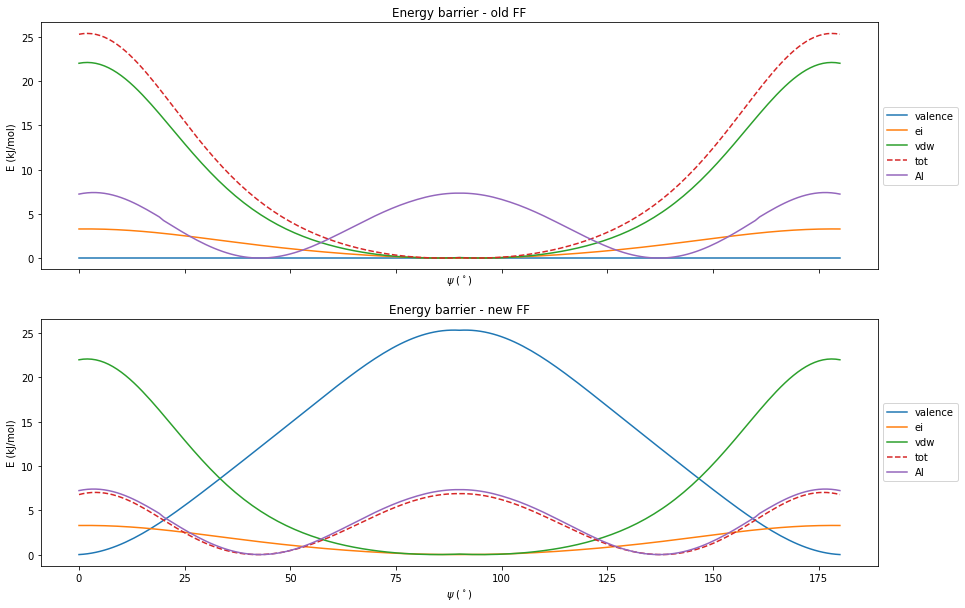

300_new
Mirroring


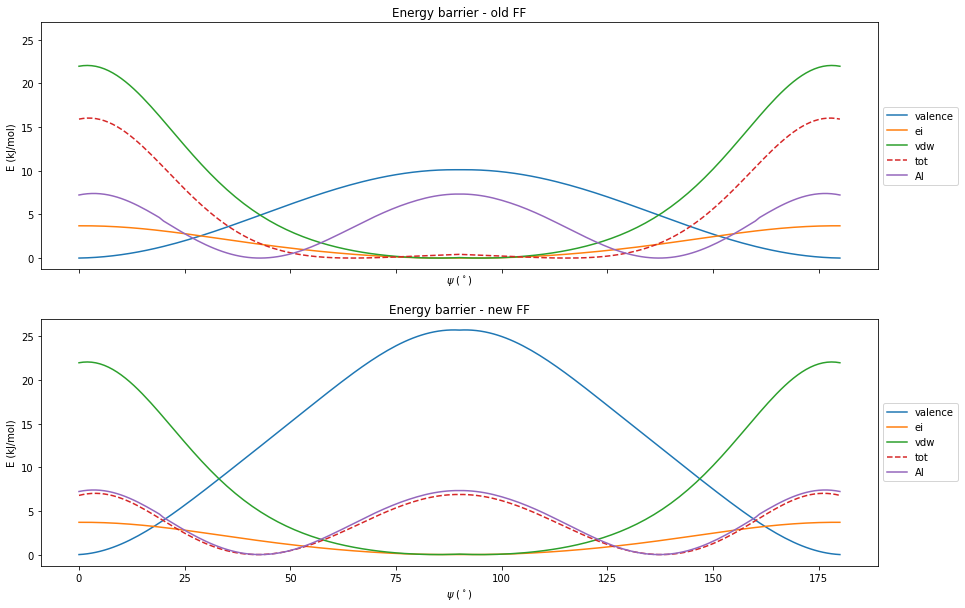

320_old
Mirroring


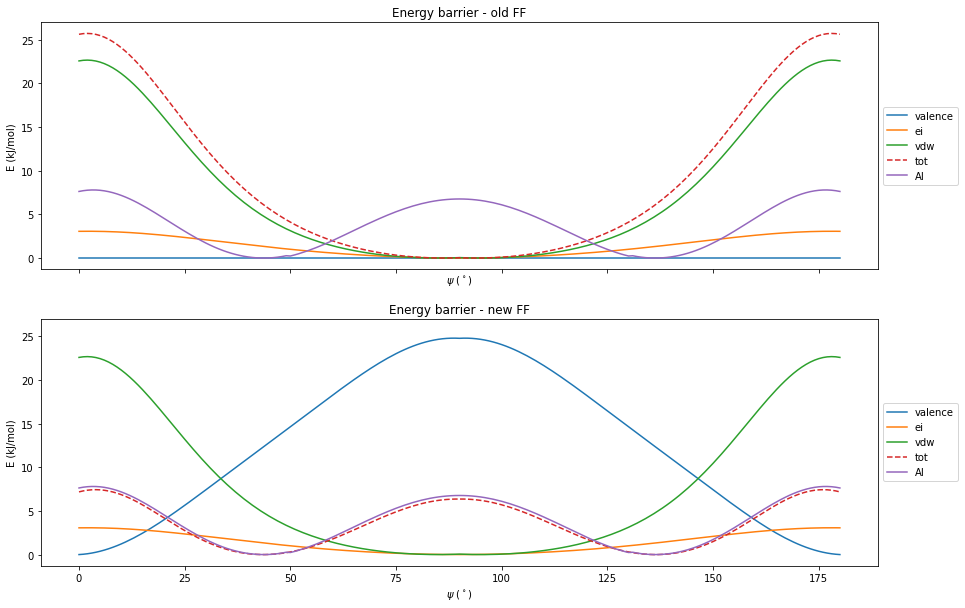

320_new
Mirroring


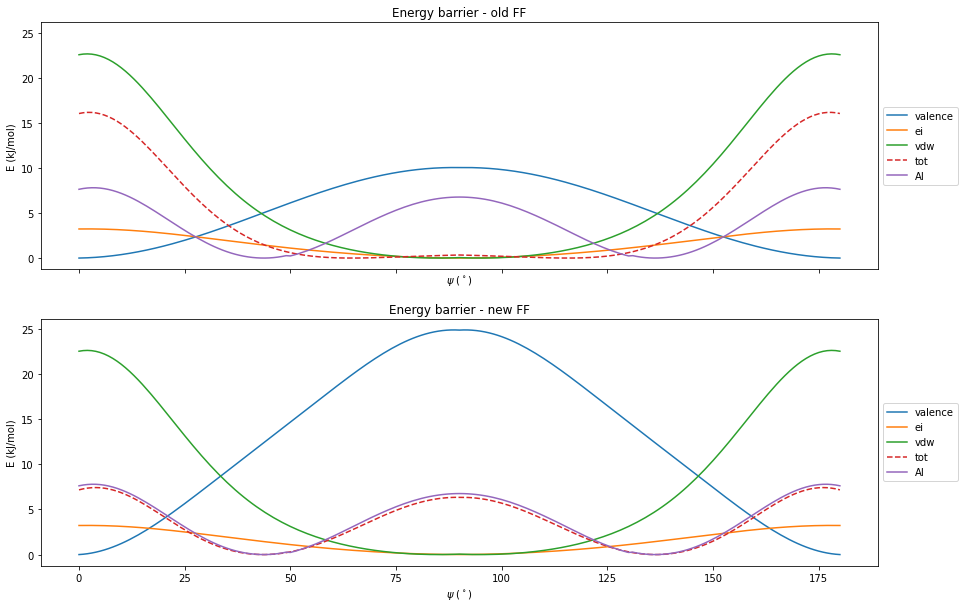

In [144]:
for name,sinfo in sinfos_cof300.items():
    pr_name = name.split('/')[0]+'_'+name.split('/')[1].split('_')[0]
    full_plot(sinfo.pr,pr_name,sinfo,ai_data_cof300[name],ff_cof300_datas[name],save_png=True)